In [3]:
from scipy.interpolate import griddata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams.update({"text.usetex": False,
                     "font.size": 20,
                     "pdf.fonttype": 42,
                     "ps.fonttype": 42})

In [4]:
df = pd.read_csv("../measurements/JPEG_manager_dyanmic2/characteristic.csv")
# df = pd.read_csv("../measurements/JPEG_manager_sparsity/characteristic.csv")

In [5]:
df.head()

,pruning_thresh,quality,technique,bandwidth,mAP_drop,frame_id,sparsity,decomposability,regularity,pictoriality,datasize_est,datasize_real,reconstruct_snr,target_cmp,target_snr
0,0.05,92,1,2.498029e+07,40,1,-1,-1,-1,-1,38398,39142,13.467377,18.473873,20
1,0.05,92,1,2.492123e+07,40,2,-1,-1,-1,-1,28669,29413,19.505306,18.517654,20
2,0.05,92,1,2.482305e+07,40,3,-1,-1,-1,-1,27481,28225,23.767583,18.590892,20
3,0.05,92,1,2.468615e+07,40,4,-1,-1,-1,-1,19647,20391,23.742502,18.693992,20
4,0.05,92,1,2.451106e+07,40,5,-1,-1,-1,-1,10792,11536,22.784839,18.827530,20


In [6]:
tensor_size = 128*26*26*4
df["cmp"] = tensor_size/df["datasize_real"]

In [7]:
jpeg_cha = pd.read_csv("/home/rex/gitRepo/split_DNN_framework/stable_tests/measurements/jpeg_snr_cha/characteristic.csv")
jpeg_cha = jpeg_cha[jpeg_cha["sparsity"]>0]
jpeg_cha = jpeg_cha[jpeg_cha["datasize_est"]>0]
tensor_size = 128*26*26 *4
jpeg_cha["ratio"] = tensor_size/jpeg_cha["datasize_est"]
pruning = [0.05, 0.1, 0.15, 0.2, 0.25,0.3,0.35]
quality = [60,70,80,90,100]

snr_samples ={}
cmp_samples ={}
window_size = 3

cha_df_group =jpeg_cha.groupby("pruning_thresh")
for p in pruning:
    cha_df = cha_df_group.get_group(p)
    cha_quality_df = cha_df.groupby("quality")
    for q in quality:
        cha_plot_df= cha_quality_df.get_group(q)
        snrs = cha_plot_df["reconstruct_snr"].to_numpy()[0:window_size]
        cmps = cha_plot_df["ratio"].to_numpy()[0:window_size]
        snr_samples[(p,q)] =snrs
        cmp_samples[(p,q)] =cmps

thresh = df["pruning_thresh"].to_numpy()
quality = df["quality"].to_numpy()
cmp_m = df["cmp"].to_numpy()

est_err3 = []
est_3 = []
est_err3_per=[]

for i in range(len(thresh)):
    sample_points = list(cmp_samples.keys())
    sample_snrs = np.mean(np.array(list(cmp_samples.values())),axis=1)
    snr_est = griddata(sample_points, sample_snrs, (thresh[i],quality[i]), method='linear')
    # snr_est = griddata(sample_points, sample_snrs, (thresh[i],quality[i]), method='linear')
    est_3.append(snr_est)
    est_err3.append(snr_est-cmp_m[i])
    est_err3_per.append(abs((snr_est-cmp_m[i])/cmp_m[i]*100))

    try:
        values = cmp_samples[(thresh[i],quality[i])]
        values = np.roll(values,1)
        values[0] = cmp_m[i]
        cmp_samples[(thresh[i],quality[i])] = values
    except:
        cmp_samples[(thresh[i],quality[i])] = np.ones(window_size)*cmp_m[i]

print(np.array(est_err3).mean())
print(np.array(est_err3).std())
print(np.array(est_err3_per).mean())

true_avged=[]
est_avged_3=[]
est_err_avged_3 = []
avg_length = 10
for i in range(len(thresh)-avg_length):
    true_avged.append(np.array(cmp_m[i:i+avg_length]).mean())
    est_avged_3.append(np.array(est_3[i:i+avg_length]).mean())
    # est_err_avged_3.append(abs(est_avged_3[-1]-true_avged[-1]))
    est_err_avged_3.append(abs(est_avged_3[-1]-true_avged[-1])/true_avged[-1] *100)

-1.4268981009011126
10.870750886251551
23.836108794549762


In [8]:
np.percentile(np.array(est_err3_per),80)

36.55270291725368

In [9]:
jpeg_cha = pd.read_csv("/home/rex/gitRepo/split_DNN_framework/stable_tests/measurements/jpeg_snr_cha/characteristic.csv")
jpeg_cha = jpeg_cha[jpeg_cha["sparsity"]>0]
jpeg_cha = jpeg_cha[jpeg_cha["datasize_est"]>0]
tensor_size = 128*26*26 *4
jpeg_cha["ratio"] = tensor_size/jpeg_cha["datasize_est"]
pruning = [0.05, 0.1, 0.15, 0.2, 0.25,0.3,0.35]
quality = [60,70,80,90,100]

snr_samples ={}
cmp_samples ={}
window_size = 6

cha_df_group =jpeg_cha.groupby("pruning_thresh")
for p in pruning:
    cha_df = cha_df_group.get_group(p)
    cha_quality_df = cha_df.groupby("quality")
    for q in quality:
        cha_plot_df= cha_quality_df.get_group(q)
        snrs = cha_plot_df["reconstruct_snr"].to_numpy()[0:window_size]
        cmps = cha_plot_df["ratio"].to_numpy()[0:window_size]
        snr_samples[(p,q)] =snrs
        cmp_samples[(p,q)] =cmps

thresh = df["pruning_thresh"].to_numpy()
quality = df["quality"].to_numpy()
cmp_m = df["cmp"].to_numpy()

est_err6 = []
est_6 = []
est_err6_per=[]

for i in range(len(thresh)):
    sample_points = list(cmp_samples.keys())
    sample_snrs = np.mean(np.array(list(cmp_samples.values())),axis=1)
    snr_est = griddata(sample_points, sample_snrs, (thresh[i],quality[i]), method='linear')
    # snr_est = griddata(sample_points, sample_snrs, (thresh[i],quality[i]), method='linear')
    est_6.append(snr_est)
    est_err6.append(snr_est-cmp_m[i])
    est_err6_per.append(abs((snr_est-cmp_m[i])/cmp_m[i]*100))

    try:
        values = cmp_samples[(thresh[i],quality[i])]
        values = np.roll(values,1)
        values[0] = cmp_m[i]
        cmp_samples[(thresh[i],quality[i])] = values
    except:
        cmp_samples[(thresh[i],quality[i])] = np.ones(window_size)*cmp_m[i]

print(np.array(est_err6).mean())
print(np.array(est_err6).std())
print(np.array(est_err6_per).mean())

true_avged=[]
est_avged_6=[]
est_err_avged_6 = []
avg_length = 10
for i in range(len(thresh)-avg_length):
    true_avged.append(np.array(cmp_m[i:i+avg_length]).mean())
    est_avged_6.append(np.array(est_6[i:i+avg_length]).mean())
    # est_err_avged_6.append(abs(est_avged_6[-1]-true_avged[-1]))
    est_err_avged_6.append(abs(est_avged_6[-1]-true_avged[-1])/true_avged[-1] *100)

-0.6357765341627436
11.91316621490386
25.049112089502025


In [10]:
np.percentile(np.array(est_err6_per),80)

35.894518870137894

In [11]:
jpeg_cha = pd.read_csv("/home/rex/gitRepo/split_DNN_framework/stable_tests/measurements/jpeg_snr_cha/characteristic.csv")
jpeg_cha = jpeg_cha[jpeg_cha["sparsity"]>0]
jpeg_cha = jpeg_cha[jpeg_cha["datasize_est"]>0]
tensor_size = 128*26*26 *4
jpeg_cha["ratio"] = tensor_size/jpeg_cha["datasize_est"]
pruning = [0.05, 0.1, 0.15, 0.2, 0.25,0.3,0.35]
quality = [60,70,80,90,100]

snr_samples ={}
cmp_samples ={}
window_size = 9

cha_df_group =jpeg_cha.groupby("pruning_thresh")
for p in pruning:
    cha_df = cha_df_group.get_group(p)
    cha_quality_df = cha_df.groupby("quality")
    for q in quality:
        cha_plot_df= cha_quality_df.get_group(q)
        snrs = cha_plot_df["reconstruct_snr"].to_numpy()[0:window_size]
        cmps = cha_plot_df["ratio"].to_numpy()[0:window_size]
        snr_samples[(p,q)] =snrs
        cmp_samples[(p,q)] =cmps

thresh = df["pruning_thresh"].to_numpy()
quality = df["quality"].to_numpy()
cmp_m = df["cmp"].to_numpy()

est_err9 = []
est_9 = []
est_err9_per=[]

for i in range(len(thresh)):
    sample_points = list(cmp_samples.keys())
    sample_snrs = np.mean(np.array(list(cmp_samples.values())),axis=1)
    snr_est = griddata(sample_points, sample_snrs, (thresh[i],quality[i]), method='linear')
    # snr_est = griddata(sample_points, sample_snrs, (thresh[i],quality[i]), method='linear')
    est_9.append(snr_est)
    est_err9.append(snr_est-cmp_m[i])
    est_err9_per.append(abs((snr_est-cmp_m[i])/cmp_m[i]*100))

    try:
        values = cmp_samples[(thresh[i],quality[i])]
        values = np.roll(values,1)
        values[0] = cmp_m[i]
        cmp_samples[(thresh[i],quality[i])] = values
    except:
        cmp_samples[(thresh[i],quality[i])] = np.ones(window_size)*cmp_m[i]

print(np.array(est_err9).mean())
print(np.array(est_err9).std())
print(np.array(est_err9_per).mean())

true_avged=[]
est_avged_9=[]
est_err_avged_9 = []
avg_length = 10
for i in range(len(thresh)-avg_length):
    true_avged.append(np.array(cmp_m[i:i+avg_length]).mean())
    est_avged_9.append(np.array(est_9[i:i+avg_length]).mean())
    # est_err_avged_9.append(abs(est_avged_9[-1]-true_avged[-1]))
    est_err_avged_9.append(abs(est_avged_9[-1]-true_avged[-1])/true_avged[-1] *100)

-0.25523515974112937
12.487524941852625
25.91015799695857


In [12]:
np.percentile(np.array(est_err9_per[100:]),80)

34.64967303867603

Text(0, 0.5, 'Compression ratio')

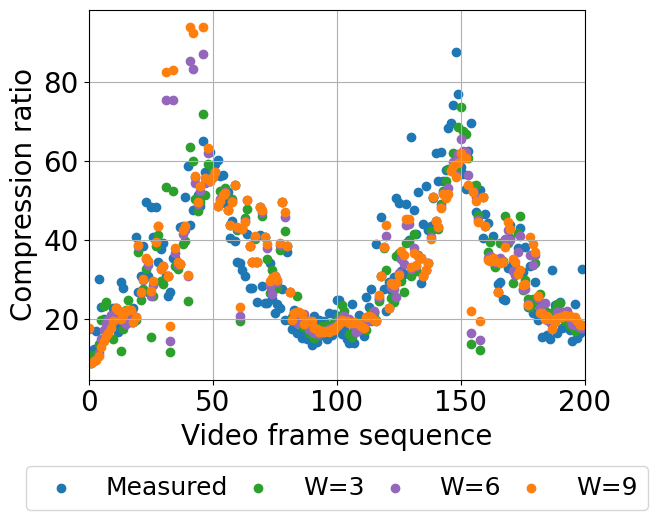

In [13]:
fig, ax1 = plt.subplots()
ax1.scatter(np.arange(200),cmp_m,label ="Measured", color="tab:blue")
ax1.scatter(np.arange(200),est_3, label="W=3",color="tab:green")
ax1.scatter(np.arange(200),est_6, label="W=6",color="tab:purple")
ax1.scatter(np.arange(200),est_9, label="W=9",color="tab:orange")
# plt.plot(cmp_m,label ="Measure")
# plt.plot(est_3, label="W=3")
# plt.plot(est_6, label="W=6")
# plt.plot(est_9, label="W=9")
ax1.legend(ncol=4,fontsize=18,loc="upper center",bbox_to_anchor=(0.5, -0.2), columnspacing=0.2)
ax1.grid()
ax1.set_xlim([0,200])
ax1.set_xlabel("Video frame sequence")
ax1.set_ylabel("Compression ratio")
# plt.savefig("./figures/cmp_est.pdf",format="pdf", bbox_inches="tight")

In [14]:
np.array(est_err_avged_6).std()

9.764849084922211

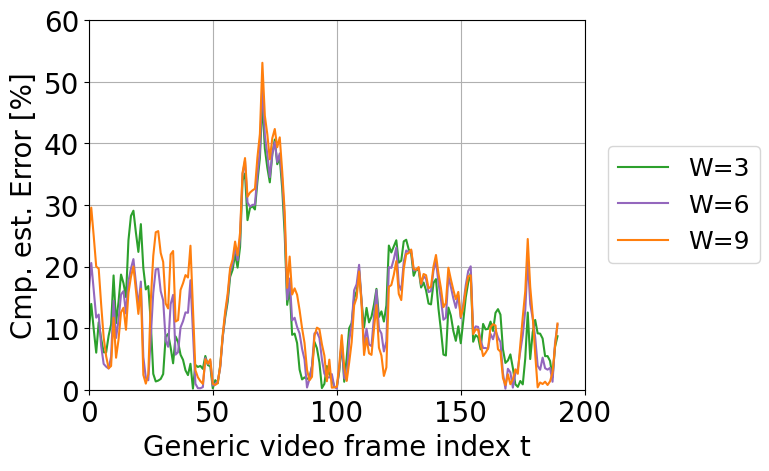

In [15]:
fig, ax1 = plt.subplots()
# ax1.plot(np.arange(len(true_avged)),true_avged,label ="Measured",color="tab:blue")
ax1.plot(np.arange(len(true_avged)),est_err_avged_3, label="W=3",color="tab:green")
ax1.plot(np.arange(len(true_avged)),est_err_avged_6, label="W=6",color="tab:purple")
ax1.plot(np.arange(len(true_avged)),est_err_avged_9, label="W=9",color="tab:orange")

ax1.legend(ncol=1,fontsize=18,loc="center",bbox_to_anchor=(1.2, 0.5), columnspacing=2)
ax1.grid()
ax1.set_ylabel("Cmp. est. Error [%]")
ax1.set_xlabel("Generic video frame index t")
ax1.set_xlim([0,200])
ax1.set_ylim([0,60])
plt.savefig("./figures/cmp_est.pdf",format="pdf", bbox_inches="tight")